
# Experimenting with California Fire Data


This notebook is a summary of all the useful and convenient information I got in my limited time with the California wildfire dataset, and also a basis for further exploration. We start from scratch, downloading all the available data, then cleaning it, morphing some of the more interesting features, and closing out with a custom graph. I've written this as more of a demonstration and an exercise for learning data APIs than anything. I did a bit more work than appears here, but it can be summarized well enough by what I left in this notebook. Read to the end to see that sweet, sweet, graph and my postmortem on writing this.

<br>

#### Notes on my code style
For any programmers who will be reading this code, I have one somewhat unusual practice I'll want to clarify upfront to avoid confusion. Sometimes in my code, you will see a pattern like this:

```python
some_var = "someval"
if True #random comment
    {some logic here}
```
and you will probably assume I am either completely incapable of understanding if statements, or that I am summoning some dark magic from the python interpreter. In reality, it's neither, it's pretty much just a way for me to mentally link a comment to a block of code. More accurately, I use this pattern (which I stole from John Carmack) as a replacement for single-use helper-functions. Thinking about them from that point of view, you will also often see that any "inputs" or "outputs" to this pseudo-function will be listed as declarations directly above it.

Granted, this pattern is more helpful in languages with stricter scoping, but because this is my first time programming Python since I adopted the pattern, I'm going to try to make it work to see how it feels with Pythons indent-based scoping.

In [1]:
from typing import *

# Importing data
import subprocess
from pathlib import Path
import os

# Data Transformation
import pandas as pd 
import numpy as np 

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

## Processing the data
Originally, I had manually downloaded a newer subset of the data, but after seeing how few records it was, and considering how I might share this notebook, I decided to write a bash script (get_data.sh) to download everything from a file of links (links.txt), and save to a local directory before continuing.

In [2]:
# Configuration

STORE_DATA_FOR_REUSE: bool = True # Allow this notebook to keep downloaded data locally for re-use
FORCE_REDOWNLOAD: bool = False # Force the notebook to ignore any locally stored data
DATA_REUSE_DIRECTORY: str = "data" # Name of the directory to store the data
LINK_FILE: str = "links.txt" # Name of the directory to store the data

In [3]:

# Asserts to prevent misconfiguration
assert DATA_REUSE_DIRECTORY != "", "The user must set a data reuse directory"

In [4]:
def read_dir_of_xlsx(root_dir): #can walk recursively too, if needed later
    wdf = pd.DataFrame([])
    for dirpath, _, filenames in os.walk(root_dir):
        for file in filenames:
            if file.endswith("_tempdata"):
                xlsx_path = os.path.join(dirpath, file)
                try:
                    # Read the file
                    df = pd.read_excel(xlsx_path)

                    
                    if True:#clean up headers
                        
                        requires_second_header_parsing: bool  = False
                        if True:# parse primary header
                            headers = df.columns.to_series()
                            tl_filter = headers.str.contains("Unnamed")
    
                            requires_second_header_parsing = len(headers[tl_filter]) > 0
    
                            headers[headers.str.contains("Unnamed")] = np.nan
                            headers = headers.ffill()
    
                        if requires_second_header_parsing:
                            secondary_headers = df.iloc[0]
                            df = df.iloc[1:]
                            headers = headers + " - " + secondary_headers.fillna("")
                            headers = headers.str.removesuffix(" - ")
    
                        # get rid of the weird newline thing (GPT ftw with these regexes)
                        headers = (
                            headers.astype(str)
                            .str.replace(r"(\\n|\r\n|\r|\n)", "", regex=True)
                            .str.replace("/", "", regex=False)
                        )
    
                        # fix the few little headers which parsed weird
                        headers[headers == "Utility Name - Utility Name"] = "Utility Name"
                        headers = headers.str.replace("Utility Name - ", "Fire Start - ")
                        for i in ["Date", "Year", "Time"]:
                            headers = headers.str.replace(
                                f"^{i}$", "Fire Start - " + i, regex=True
                            )
    
                        df.columns = headers

                    # Files from some companies (*coughcoughsdgecoughcough**), have footers as well,
                    # placed one space under the lowest record. I would detect them here, but there really isn't a need, they'll be removed later
                    
                    wdf = pd.concat([wdf, df], axis=0)
                    print(f"Read: {xlsx_path}")

                except Exception as e:
                    print(f"Failed to read {xlsx_path}: {e}")
            first = False
    return wdf


reuse_possible: bool = Path(f"{DATA_REUSE_DIRECTORY}/saved_data.csv").exists()
performed_a_download: bool = False

if FORCE_REDOWNLOAD or not reuse_possible:
    performed_a_download = True
    print("downloading data...")
    subprocess.run(["./get_data.sh", LINK_FILE, DATA_REUSE_DIRECTORY], check=True)
    print("reading data...")
    df = read_dir_of_xlsx(DATA_REUSE_DIRECTORY)
    print("deleting temporary files...")
    subprocess.run(f"rm {DATA_REUSE_DIRECTORY}/*_tempdata", shell=True, check=True)
    
if not FORCE_REDOWNLOAD and reuse_possible:
    print("reading cached data...")
    df = pd.read_csv(f"{DATA_REUSE_DIRECTORY}/saved_data.csv")
else: 
    performed_a_download = True
    print("downloading data...")
    subprocess.run(["./get_data.sh", LINK_FILE, DATA_REUSE_DIRECTORY], check=True)
    print("reading data...")
    df = read_dir_of_xlsx(DATA_REUSE_DIRECTORY)
    print("deleting temporary files...")
    subprocess.run(f"rm {DATA_REUSE_DIRECTORY}/*_tempdata", shell=True, check=True)
        
        
    


if STORE_DATA_FOR_REUSE and performed_a_download:
    print("caching data for future use...")
    df.to_csv(f"{DATA_REUSE_DIRECTORY}/saved_data.csv")


# NOTE: There is one file which fails excel parsing. I checked, and it's only 43 records, so honestly I'm just gonna let it be.

reading cached data...


### Basic Cleanup
We'll perform a bit of type coercion for the some of the more interesting-looking numeric columns, we'll remove all columns with 80% or more null values and all empty rows, and lastly, we make sure we have clean column names

In [5]:
print(df.shape)
df["Location - Latitude"] = pd.to_numeric(df["Location - Latitude"], errors = "coerce")
df["Location - Longitude"] = pd.to_numeric(df["Location - Longitude"], errors = "coerce")

df["Fire Start - Time"] = pd.to_datetime(df["Fire Start - Time"], errors = "coerce")
df["Fire Start - Date"] = pd.to_datetime(df["Fire Start - Date"], errors = "coerce")

df["Outage - Time"] = pd.to_datetime(df["Outage - Time"],errors="coerce")
df["Fire Start - Time"] = pd.to_datetime(df["Fire Start - Time"],errors="coerce")

df["Outage - Delay"] = (df["Outage - Time"] - df["Fire Start - Time"]).dt.total_seconds()/3600

df = df.dropna(axis=1, thresh = len(df)*0.80)
df = df.dropna(axis=0, how = "all")
df = df.reset_index(drop = True)
df.columns = df.columns.str.strip()

/tmp/ipykernel_29066/3486451192.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Fire Start - Time"] = pd.to_datetime(df["Fire Start - Time"], errors = "coerce")


### String Mapping

Unfortunately, some of the most important pieces of data are pretty inconsistently encoded in strings. We'll map them to approximate median values, and make it easy to change in the future (if our medians are actually way off)

In [18]:
fire_sizes = [0.01,0.25,6,60,180,650,2700,6000]

fire_size_map = {
  'Unknown': 0.01,
    
  '<3 meters of linear travel': 0,
 'Less than three (3) meters of linear travel': 0,
  '1 meter - < 3 meters': 0,
  'Less than three {3} meters of linear travel': 0,
    
  'Structure-only': 1,
  'Structure Only': 1,
    
  '3 meters - 0.25 Acres': 1,
  '<0.25': 1,
 'Less Than .26 Acres': 1,
    
  '.26 - 9.99 Acres': 2,
  '0.25 - 10 Acres': 2,
  '0.26-9.99': 2,
    
  '10 - 99 Acres': 3,
  '10-99': 3,
  '10 - 100 Acres': 3,
    
      '100 + Acres': 4,
      '100+ Acres': 4,
    
  '100-299': 4,
  '100 - 299 Acres': 4,
    
  '300-999': 5,
  '300 - 999 Acres': 5,

  '1,000-4,999': 6,
    
  'Greater than 5000 Acres': 7,
  '>5,000': 7,
    
}

df["Fire - Size (as int)"] = df["Fire - Size"].map(lambda:x fire_sizes[fire_size_map[x]])




field_obs_map = {#Not a hundred percent sure what all of these mean, but we'll take a swing
    
    'Unknown': 'Unknown',
    'Under Investigation': 'Unknown',
    
    'Other': 'Other',
    'Other Fire: Non-PG&E related': 'Other',
    'Normal Operation': 'Other', # "Ahh yeah, the fire? Oh, you must be new here, see, thats just normal operation. Don't worry, you'll get used to it"
    
    'Vandalism/Theft': 'Vandalism/Theft',
    'Vandalism': 'Vandalism/Theft',
    'Vandalism/theft': 'Vandalism/Theft',
    
    'Equipment/Facility Failure': 'Equipment/Facility Failure',
    'Equipment - PG&E': 'Equipment/Facility Failure',
    'Equipment failure': 'Equipment/Facility Failure',
    'Equipment - Overloaded': 'Equipment/Facility Failure',
    'Equipment/ Facility Failure': 'Equipment/Facility Failure',
    'Contamination': 'Equipment/Facility Failure',
    
    'Weather': 'Weather',
    'Lightning': 'Weather',
    'Weather - High Wind': 'Weather',
    
    
    'Contact from object': 'Contact',
    'Contact Between Third Party \nFacility on Pole and Supply Lines': 'Contact',
    'Wire-Wire Contact': 'Contact',
    'Wire-to-wire contact': 'Contact',
    'Contact - 3rd Party': 'Contact',
    'Contact from Object': 'Contact',
    'Contact From Object': 'Contact',
    'Contact Between Third Party Facility on Pole and Supply Lines': 'Contact',
    'Contact - Customer': 'Contact',
    'Contact - Animal - Other': 'Contact',
    'Contact - Animal - Bird': 'Contact',

    'Vegetation': 'Vegetation',#kinda different, maybe? because of who can be considered at fault?
}

df['Field Observations - Suspected Initiating Event'] = (
    df['Field Observations - Suspected Initiating Event'].map(field_obs_map)
)


### Plotting

Now we're ready to take a gander at a visualization. Specifically, we want to look at the different incidents which cause fires, and how different incidents may cause different sizes of fires. The goal for this visualization is to make that connection (if it exists) clear.


<br>
<br>


We'll start by looking at distributions and much data we actually have.

<Axes: xlabel='Field Observations - Suspected Initiating Event', ylabel='Count'>

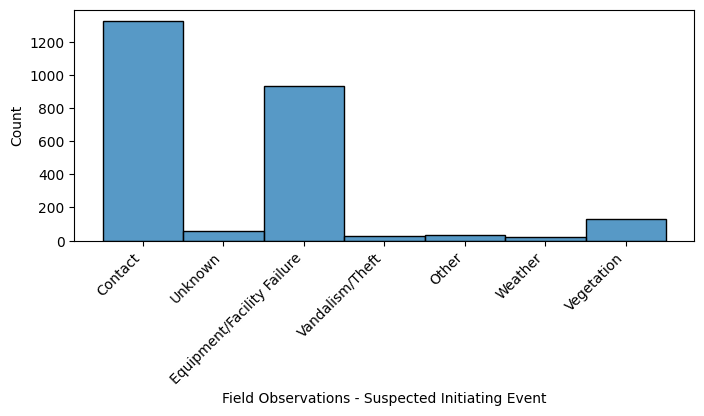

In [25]:
plt.figure(figsize=(8, 3))
plt.xticks(rotation=45, ha="right")

sns.histplot(x = df[ 'Field Observations - Suspected Initiating Event'])

<Axes: xlabel='Fire - Size (as int)', ylabel='Count'>

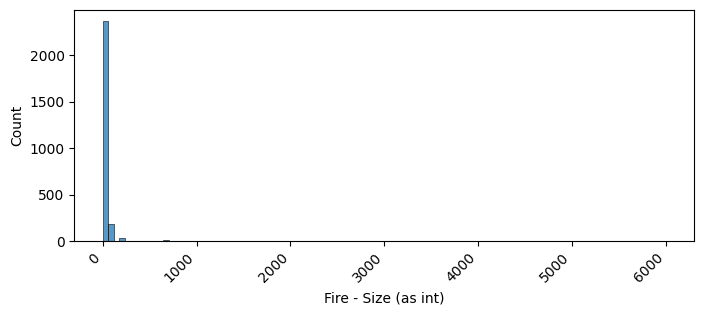

In [24]:
plt.figure(figsize=(8, 3))
plt.xticks(rotation=45, ha="right")

sns.histplot(x = df[ 'Fire - Size (as int)'])

Seeing these plots gives me an idea. It's pretty hard to see which incident types are actually worth looking into, because the size of fires resulting from these different causes, as far as I can tell so far, may be drastically different. However, we are mostly unable to plot them against each other, because of the heavily weighted distributions. I believe this calls for a histogram with stacked bars, but the stacks are so relatively short for some of these it would be practically useless. What we need is more of a tracking of distribution. We need to see what proportion of fires of each size are started by which kind of incident. I think I'll make the same stacked-color histogram, but with all the bars are equal height, so we can see the proportions as opposed to the sheer size.

*Update: I don't think this is something seaborn is capable of, I will need to go a bit more low-level with matplotlib*

*Update #2: I've made the stacked histogram-ey thing, but having each bar be the same size makes the visual representation an unnatural comparison to reality. After all, 50% of fires <.25 acres probably haven't done the same damage as 50% of the 100->500 acre fires, but it without careful thought, the graph makes it look that way. The solution I'm going to puruse is to make each bars width proportional to the total amount of burnt acreage by that size of fire, that way all the proportions can be compared horizontally as well as vertically.*

[1.0e-02 2.5e-01 6.0e+00 6.0e+01 1.8e+02 6.5e+02 2.7e+03 6.0e+03]
['Contact' 'Unknown' 'Equipment/Facility Failure' 'Vandalism/Theft'
 'Other' 'Weather' 'Vegetation']
Fire - Size (as int)
0.01       586
0.25       732
6.00       994
60.00      177
180.00      29
650.00      14
2700.00      1
6000.00      4
Name: count, dtype: int64


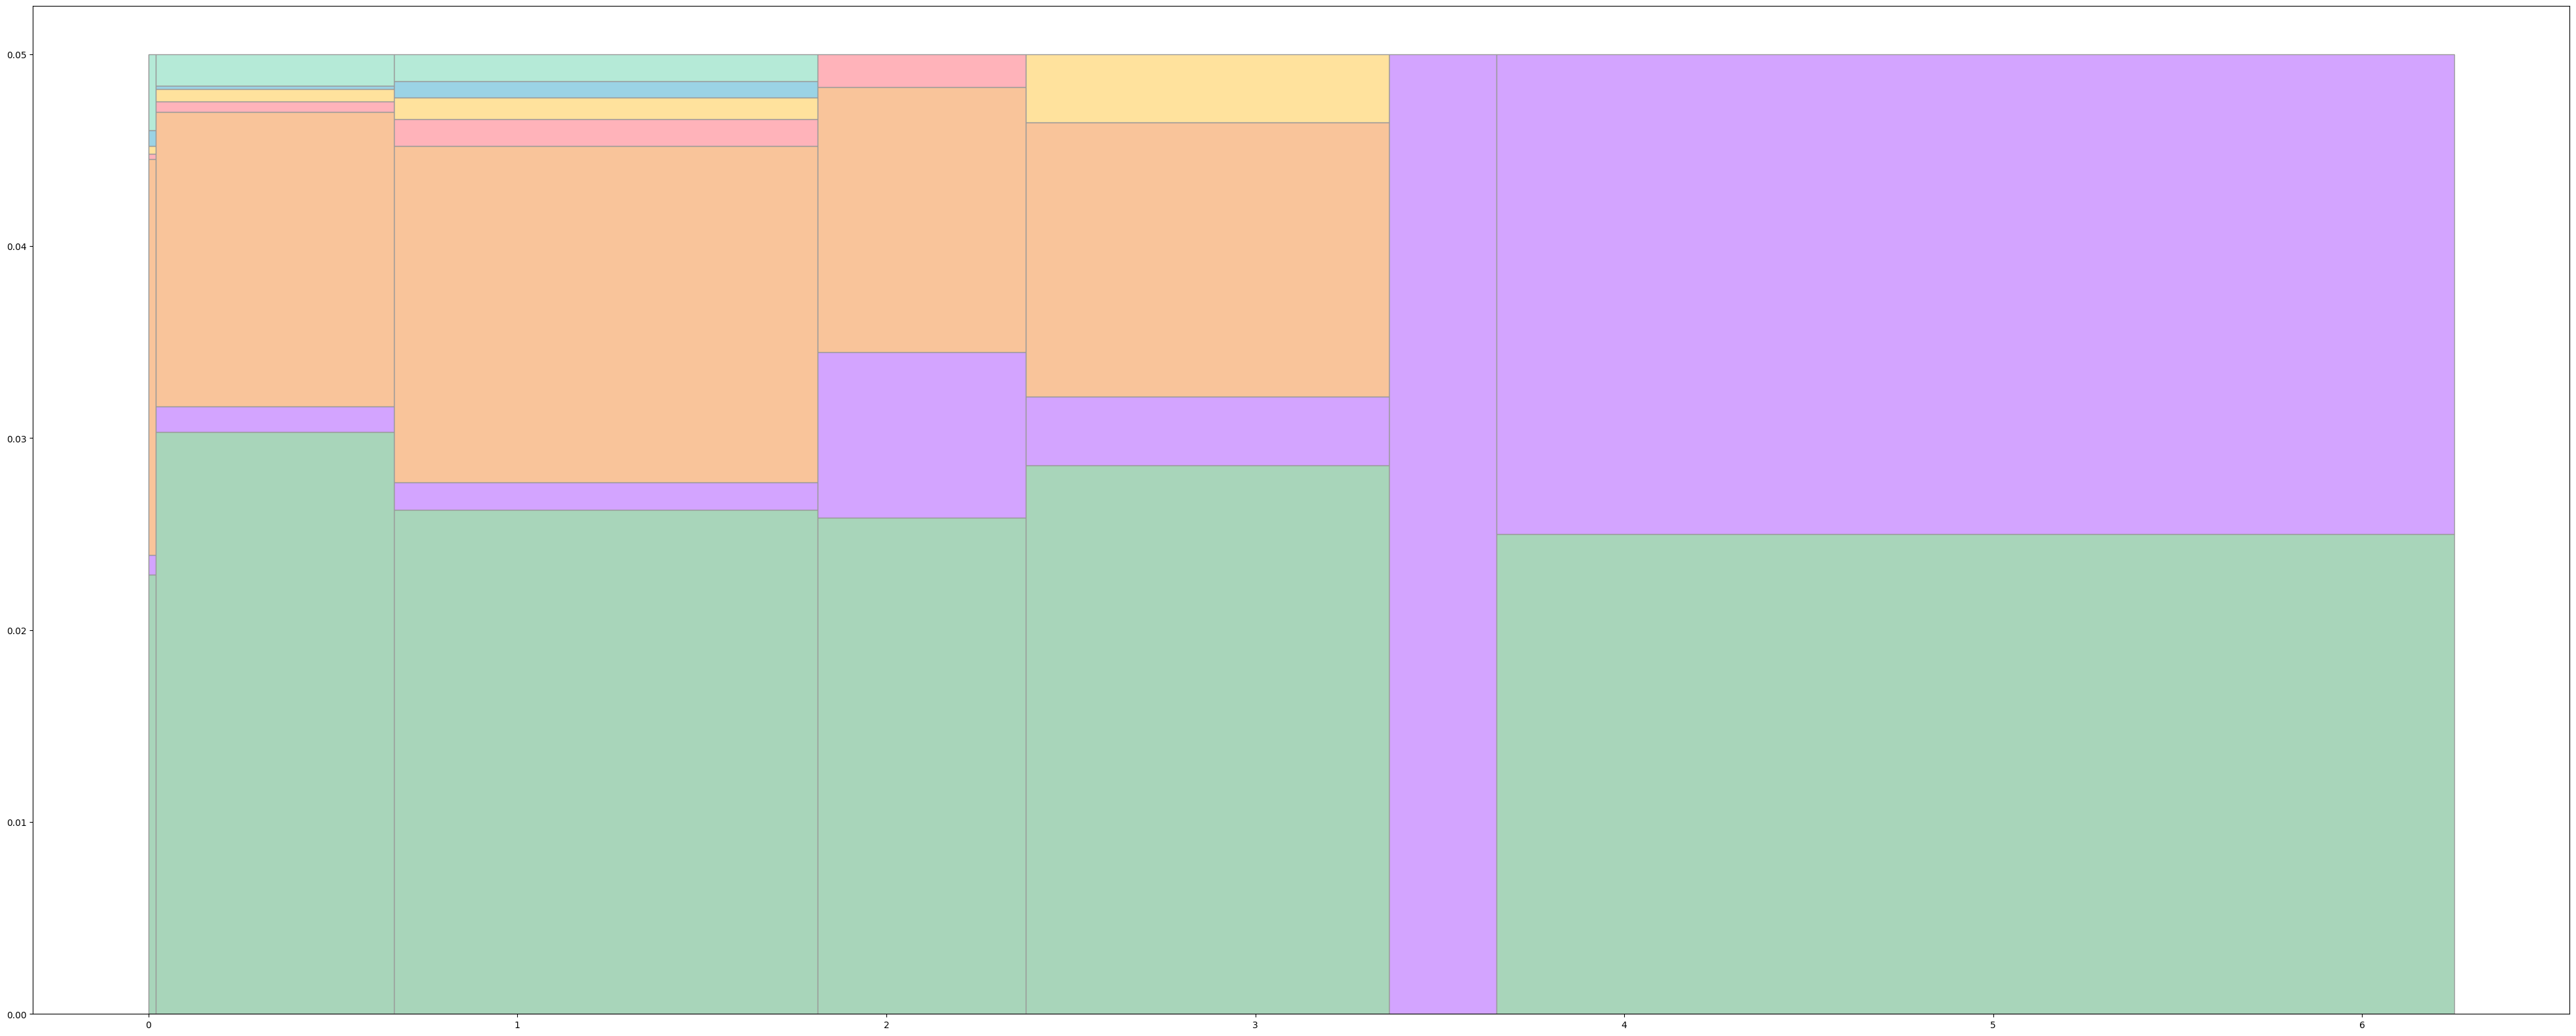

In [22]:
df = df.dropna(subset = ["Fire - Size (as int)"])
df["high_impact"] = df['Fire - Size (as int)'] > 10
df["plt_helper"] = 0
idx = df.index[df["high_impact"]][0]
df[idx,"plt_helper"] = 100

idx = df.index[~df["high_impact"]][0]
df[idx,"plt_helper"] = 100

sm_df = df[[
    'Fire - Size (as int)',
    'Field Observations - Suspected Initiating Event',
]]

grouped = sm_df.groupby(['Fire - Size (as int)'])['Field Observations - Suspected Initiating Event'].value_counts()

total_counts = grouped.reset_index().groupby(['Fire - Size (as int)'])['count'].sum()

tc = total_counts.copy().reset_index()
tc['total_amt_burned'] = tc['Fire - Size (as int)']*tc['count']
proportion_of_burnt_area = tc['total_amt_burned']/(tc['total_amt_burned'].sum())

fire_sizes = df['Fire - Size (as int)'].unique()
observations = df['Field Observations - Suspected Initiating Event'].dropna().unique()

fire_sizes.sort()

print(fire_sizes)
print(observations)
print(total_counts)

# W to ChatGPT for coming up with these colors
colors = [
    '#A8D5BA',  # Contact - pastel green
    '#D3A4FF',  # Unknown - pastel purple
    '#F9C49A',  # Equipment/Facility Failure - pastel orange
    '#FFB3BA',  # Vandalism/Theft - pastel pink
    '#FFE29D',  # Other - pastel yellow
    '#9BD3E5',  # Weather - pastel blue
    '#B5EAD7',  # Vegetation - soft green
]
edgecolor = '#999999'  # soft gray

fig_w = 50
fig_h = 20

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

hor_increments = fig_w/len(fire_sizes)
vert_mult = 1/fig_h

cur_h_pos = 0
for fire_size_idx in range(len(fire_sizes)):
    cur_v_pos = 0
    for obs_idx in range(len(observations)):
        if True: #For marking purposes: Ensure the observation has existed for this record
            gpd = grouped.reset_index()
            
            if 0 == len(
                gpd.loc[
                    (gpd['Fire - Size (as int)'] == fire_sizes[fire_size_idx])
                    & (gpd['Field Observations - Suspected Initiating Event'] == observations[obs_idx])
            ]):
                continue

        bar_height = grouped[(fire_sizes[fire_size_idx],observations[obs_idx])]/total_counts[(fire_sizes[fire_size_idx])]
        ax.bar(
            cur_h_pos,
            bar_height*vert_mult,
            bottom = cur_v_pos,
            width = proportion_of_burnt_area[fire_size_idx]*hor_increments,
            align = 'edge',
            
            color = colors[obs_idx],
            edgecolor = edgecolor
        )
        
        cur_v_pos += (bar_height*vert_mult)
        
    cur_h_pos += proportion_of_burnt_area[fire_size_idx]*hor_increments
plt.show()